In [1]:
import cubehelix
from joblib import Parallel, delayed
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
import pandas as pd
import seaborn as sns

import msaf       # Develop branch
import mir_eval   # Uri's fork: https://github.com/urinieto/mir_eval
from mir_eval.segment import tree

# Beatuiful seaborn plots
sns.set(style="white")
%matplotlib inline

# Colorhelix config
cx = cubehelix.cmap(reverse=True, start=0.2, rot=-0.4, minLight=0.45, maxLight=1.0)

# SALAMI Path
SALAMI_path = "/home/uri/datasets/Segments/references/"
SALAMI_path = "/Users/uri/datasets/Segments/references/"

In [2]:
def gen_synthetic_labels(bounds):
    labels = []
    [labels.append(np.random.random(len(level) - 1)) for level in bounds]
    return labels

def evaluate_flat(ref_times, est_times, w, trim=False):
    ref_times = np.asarray(ref_times).flatten()
    est_times = np.asarray(est_times).flatten()
    ref_inter = np.asarray(zip(ref_times[:], ref_times[1:]))
    est_inter = np.asarray(zip(est_times[:], est_times[1:]))
    p, r, f = mir_eval.segment.detection(ref_inter, est_inter, trim=trim, window=w)
    R2E, E2R = mir_eval.segment.deviation(ref_inter, est_inter, trim=trim)
    print "F: %.2f\t P: %.2f\t R: %.2f" % (f * 100, p * 100, r * 100)
    print "R2E: %.2f\t E2R: %.2f" % (R2E, E2R)
    return f, p, r

def evaluate_hier(bounds1, bounds2, levels1=None, levels2=None, title=None, figsize=(7,3), 
                  ratios=[1,1], plot=True):
    labels1 = gen_synthetic_labels(bounds1)
    labels2 = gen_synthetic_labels(bounds2)
    tree1 = tree.SegmentTree(bounds1, labels1, levels1)
    tree2 = tree.SegmentTree(bounds2, labels2, levels2)
    res = 0.1
    for ws in [0.5, 3.0, 15, 30, None]:
        if ws is None:
            w = None
        else:
            w = int(ws / res)
        T_o, T_u, T_f = mir_eval.segment.hmeasure(tree1, tree2, transitive=True, window=w, res=res)
        if ws is None:
            ws = np.inf
        print "w: %.1f\t Tu: %.2f\t To: %.2f" % (ws, T_u * 100, T_o * 100)
    if plot:
        plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(2, 1, height_ratios=ratios) 
        plt.subplot(gs[0])
        msaf.plotting.plot_tree(tree1, title="Reference", res=None, cmap_id=cx)
        plt.subplot(gs[1])
        msaf.plotting.plot_tree(tree2, title="Estimation", res=None, cmap_id=cx)
        plt.tight_layout()

def remove_level(bounds, levels, level_id):
    for i, level in enumerate(levels):
        if level_id == level:
            bounds.pop(i)
            levels.pop(i)
            break

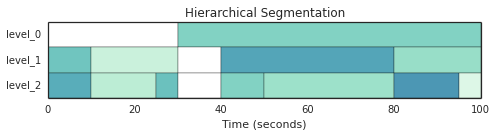

In [51]:
# Synthetic example
est_bounds = [[0, 30, 100], [0, 10, 30, 40, 80, 100], [0, 10, 25, 30, 40, 50, 80, 95, 100]]
est_labels = gen_synthetic_labels(est_bounds)
est_tree = tree.SegmentTree(est_bounds, est_labels)
plt.figure(figsize=(7,2))
msaf.plotting.plot_tree(est_tree, title="Hierarchical Segmentation", res=None, cmap_id=cx)
plt.tight_layout()
plt.savefig("../figs/hier-example.pdf")

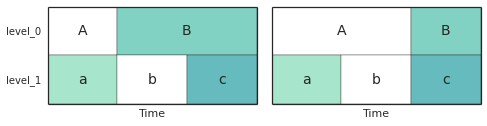

In [52]:
# Synthetic example (1)
orig_size = matplotlib.rcParams["font.size"]
matplotlib.rcParams["font.size"] = 14.

est_bounds1 = [[0, 10, 30], [0, 10, 20, 30]]
est_labels1 = gen_synthetic_labels(est_bounds1)
est_tree1 = tree.SegmentTree(est_bounds1, est_labels1)

est_bounds2 = [[0, 20, 30], [0, 10, 20, 30]]
est_labels2 = est_labels1
est_tree2 = tree.SegmentTree(est_bounds2, est_labels2)

plt.figure(figsize=(7,2))
plt.subplot(121)
msaf.plotting.plot_tree(est_tree1, title="", res=None, cmap_id=cx)
plt.xticks([],[])
plt.tight_layout()
plt.xlabel("Time")

# Annotate level 0
plt.gca().text(5, .75, 'A', horizontalalignment='center', verticalalignment='center')
plt.gca().text(20, .75, 'B', horizontalalignment='center', verticalalignment='center')

# Annotate level 1
plt.gca().text(5, .25, 'a', horizontalalignment='center', verticalalignment='center')
plt.gca().text(15, .25, 'b', horizontalalignment='center', verticalalignment='center')
plt.gca().text(25, .25, 'c', horizontalalignment='center', verticalalignment='center')

plt.subplot(122)
msaf.plotting.plot_tree(est_tree2, title="", res=None, cmap_id=cx)
plt.xticks([],[])
plt.yticks([],[])
plt.tight_layout()
plt.xlabel("Time")

# Annotate level 0
plt.gca().text(10, 0.75, 'A', horizontalalignment='center', verticalalignment='center')
plt.gca().text(25, 0.75, 'B', horizontalalignment='center', verticalalignment='center')

# Annotate level 1
plt.gca().text(5, .25, 'a', horizontalalignment='center', verticalalignment='center')
plt.gca().text(15, .25, 'b', horizontalalignment='center', verticalalignment='center')
plt.gca().text(25, .25, 'c', horizontalalignment='center', verticalalignment='center')

plt.savefig("../figs/toy-examples.pdf")
matplotlib.rcParams["font.size"] = orig_size

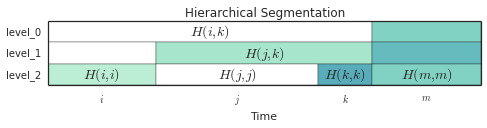

In [4]:
# Synthetic example (2)
orig_size = matplotlib.rcParams["font.size"]
matplotlib.rcParams["font.size"] = 14.
est_bounds = [[0, 30, 40], [0, 10, 30, 40], [0, 10, 25, 30, 40]]
est_labels = gen_synthetic_labels(est_bounds)
est_tree = tree.SegmentTree(est_bounds, est_labels)
plt.figure(figsize=(7,2))
msaf.plotting.plot_tree(est_tree, title="Hierarchical Segmentation", res=None, cmap_id=cx)
plt.xticks([5, 17.5, 27.5, 35], ["$i$", "$j$", "$k$", "$m$"])
plt.tight_layout()
plt.xlabel("Time")

# Annotate level 2
plt.gca().text(5, 0.165, '$H(i,i)$', horizontalalignment='center', verticalalignment='center')
plt.gca().text(17.5, 0.165, '$H(j,j)$', horizontalalignment='center', verticalalignment='center')
plt.gca().text(27.5, 0.165, '$H(k,k)$', horizontalalignment='center', verticalalignment='center')
plt.gca().text(35, 0.165, '$H(m,m)$', horizontalalignment='center', verticalalignment='center')

# Annotate level 1
plt.gca().text(20, 0.5, '$H(j,k)$', horizontalalignment='center', verticalalignment='center')

# Annotate level 0
plt.gca().text(15, .845, '$H(i,k)$', horizontalalignment='center', verticalalignment='center')

plt.savefig("../figs/hier-example.pdf")
matplotlib.rcParams["font.size"] = orig_size

F: 57.14	 P: 100.00	 R: 40.00
R2E: 10.00	 E2R: 0.00
w: 0.5	 Tu: 40.00	 To: 100.00
w: 3.0	 Tu: 40.00	 To: 100.00
w: 15.0	 Tu: 39.39	 To: 52.77
w: 30.0	 Tu: 69.46	 To: 49.75
w: inf	 Tu: 80.00	 To: 49.75


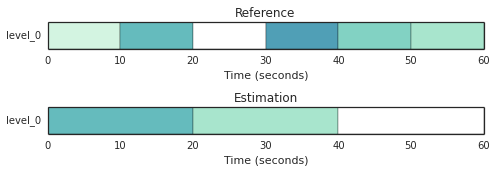

In [53]:
# Flat vs flat
f1 = [[0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 20, 40, 60]]
f, p, r = evaluate_flat(f1, f2, 3, trim=True)
evaluate_hier(f1, f2, title="Flat vs Flat", figsize=(7,2.5))
plt.savefig("../figs/flat-flat.pdf")

w: 0.5	 Tu: 0.00	 To: 100.00
w: 3.0	 Tu: 0.00	 To: 100.00
w: 15.0	 Tu: 18.60	 To: 93.71
w: 30.0	 Tu: 37.10	 To: 71.46
w: inf	 Tu: 53.44	 To: 66.58


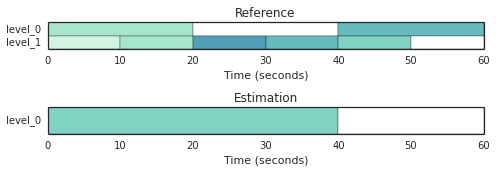

In [54]:
#Hierarchical vs Flat Larger Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 40, 60]]
evaluate_hier(h1, f2, title="Hierarchical vs Flat Large Scale", figsize=(7,2.5))
plt.savefig("../figs/hier-flatlarger.pdf")

w: 0.5	 Tu: 0.00	 To: 100.00
w: 3.0	 Tu: 0.00	 To: 100.00
w: 15.0	 Tu: 37.21	 To: 100.00
w: 30.0	 Tu: 69.66	 To: 100.00
w: inf	 Tu: 80.16	 To: 100.00


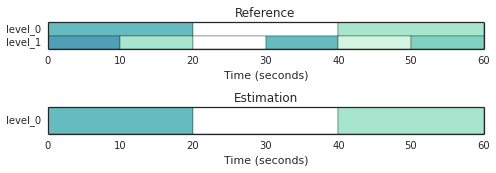

In [55]:
#Hierarchical vs Flat Large Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 20, 40, 60]]
evaluate_hier(h1, f2, title="Hierarchical vs Flat Large Scale", figsize=(7,2.5))
plt.savefig("../figs/hier-flatlarge.pdf")

w: 0.5	 Tu: 100.00	 To: 100.00
w: 3.0	 Tu: 100.00	 To: 100.00
w: 15.0	 Tu: 62.79	 To: 100.00
w: 30.0	 Tu: 30.34	 To: 100.00
w: inf	 Tu: 19.84	 To: 100.00


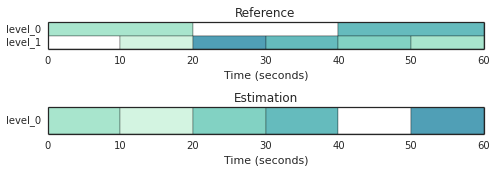

In [56]:
# Hierarchical vs Flat Small Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 10, 20, 30, 40, 50, 60]]
evaluate_hier(h1, f2, title="Hierarchical vs Flat Small Scale", figsize=(7,2.5))
plt.savefig("../figs/hier-flatsmall.pdf")

w: 0.5	 Tu: 100.00	 To: 55.56
w: 3.0	 Tu: 98.16	 To: 56.43
w: 15.0	 Tu: 46.31	 To: 86.28
w: 30.0	 Tu: 21.80	 To: 92.47
w: inf	 Tu: 13.16	 To: 93.94


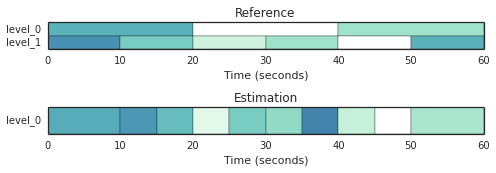

In [43]:
# Hierarchical vs Flat Smaller Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60]]
evaluate_hier(h1, f2, title="Hierarchical vs Flat Small Scale", figsize=(7,2.5))
plt.savefig("../figs/hier-flatsmaller.pdf")

w: 0.5	 Tu: 100.00	 To: 100.00
w: 3.0	 Tu: 100.00	 To: 100.00
w: 15.0	 Tu: 100.00	 To: 98.32
w: 30.0	 Tu: 100.00	 To: 78.81
w: inf	 Tu: 100.00	 To: 61.85


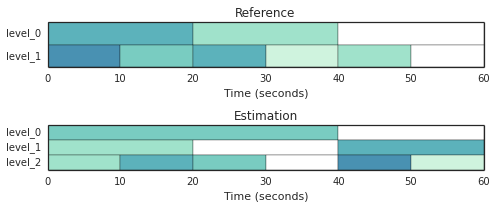

In [44]:
# Hierarchical vs Hierarchical
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
h2 = [[0, 40, 60], [0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
evaluate_hier(h1, h2, title="Hierarchical vs Hierarchical", figsize=(7,3))
plt.savefig("../figs/hier-hiercomp.pdf")

w: 0.5	 Tu: 78.17	 To: 79.00
w: 3.0	 Tu: 95.39	 To: 95.06
w: 15.0	 Tu: 75.53	 To: 74.92
w: 30.0	 Tu: 61.81	 To: 82.67
w: inf	 Tu: 56.55	 To: 95.58


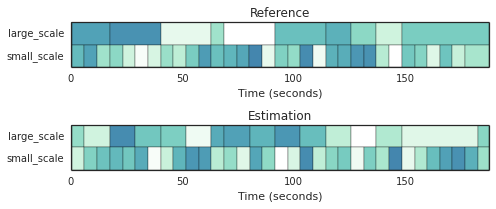

In [57]:
jams_file = "SALAMI_636.jams"
hier_bounds1, hier_labels1, hier_levels1 = msaf.io.read_hier_references(SALAMI_path + jams_file, annotation_id=0)
hier_bounds2, hier_labels2, hier_levels2 = msaf.io.read_hier_references(SALAMI_path + jams_file, annotation_id=1)

# Remove the function level
hier_levels1 = list(hier_levels1)
hier_levels2 = list(hier_levels2)
remove_level(hier_bounds1, hier_levels1, "function")
remove_level(hier_bounds2, hier_levels2, "function")

# Evaluate
evaluate_hier(hier_bounds1, hier_bounds2, hier_levels1, hier_levels2, title="SALAMI vs SALAMI", figsize=(7,3))
plt.savefig("../figs/SALAMI-SALAMI.pdf")

w: 0.5	 Tu: 14.28	 To: 100.00
w: 3.0	 Tu: 19.85	 To: 99.91
w: 15.0	 Tu: 61.63	 To: 56.13
w: 30.0	 Tu: 76.14	 To: 53.12
w: inf	 Tu: 90.29	 To: 16.39


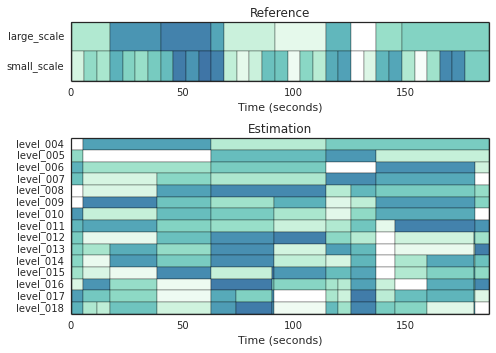

In [47]:
jams_file = "SALAMI_636.jams"
olda_file = "/home/uri/Projects/hier_eval/test/SALAMI_636_OLDA.jams"
olda_file = "/Users/uri/NYU/Spring14/hier_eval/test/SALAMI_636_OLDA.jams"
hier_bounds1, hier_labels1, hier_levels1 = msaf.io.read_hier_references(SALAMI_path + jams_file)
hier_bounds2, hier_labels2, hier_levels2 = msaf.io.read_hier_references(olda_file)

# Remove the function level from SALAMI
hier_levels1 = list(hier_levels1)
remove_level(hier_bounds1, hier_levels1, "function")

# Evaluate
evaluate_hier(hier_bounds1, hier_bounds2, hier_levels1, hier_levels2, title="SALAMI vs OLDA", figsize=(7,5), ratios=[1,3])
plt.savefig("../figs/SALAMI-OLDA.pdf")

In [8]:
# Automatically set w
def analyze_salami(salami_file, windows):
    # Read annotations
    try:
        bounds1, labels1, levels1 = msaf.io.read_hier_references(salami_file.ref_file, annotation_id=0)
        bounds2, labels2, levels2 = msaf.io.read_hier_references(salami_file.ref_file, annotation_id=1)

        # Convert to tree
        labels1 = gen_synthetic_labels(bounds1)
        labels2 = gen_synthetic_labels(bounds2)
        tree1 = tree.SegmentTree(bounds1, labels1, levels1)
        tree2 = tree.SegmentTree(bounds2, labels2, levels2)

        # Evaluate
        print "Evaluating %s..." % salami_file.ref_file
        res = 0.1
        results = {}
        results["file"] = os.path.basename(salami_file.ref_file)
        for ws in windows:
            if ws is None:
                w = None
            else:
                w = int(ws / res)
            T_o, T_u, T_f = mir_eval.segment.hmeasure(tree1, tree2, transitive=False, window=w, res=res)
            if ws is None:
                ws = np.inf
            results["Tf_" + str(ws)] = T_f
            results["To_" + str(ws)] = T_o
            results["Tu_" + str(ws)] = T_u
    except:
        return []
    
    return results

n_jobs = 8
salami_files = msaf.io.get_dataset_files("/home/uri/datasets/Segments/", ds_name="SALAMI")
windows = [0.5, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# Run in parallel
raw_results = Parallel(n_jobs=n_jobs)(delayed(analyze_salami)(salami_file, windows) 
                                      for salami_file in salami_files[:])

# Aggregate results in pandas format
results = pd.DataFrame()
for r in raw_results:
    if r != []:
        results = results.append(r, ignore_index=True)

Evaluating /home/uri/datasets/Segments/references/SALAMI_822.jams...
Evaluating /home/uri/datasets/Segments/references/SALAMI_748.jams...
Evaluating /home/uri/datasets/Segments/references/SALAMI_396.jams...
Evaluating /home/uri/datasets/Segments/references/SALAMI_550.jams...
Evaluating /home/uri/datasets/Segments/references/SALAMI_1028.jams...
Evaluating /home/uri/datasets/Segments/references/SALAMI_584.jams...
Evaluating /home/uri/datasets/Segments/references/SALAMI_960.jams...
Evaluating /home/uri/datasets/Segments/references/SALAMI_564.jams...
Evaluating /home/uri/datasets/Segments/references/SALAMI_540.jams...Evaluating /home/uri/datasets/Segments/references/SALAMI_1338.jams...Evaluating /home/uri/datasets/Segments/references/SALAMI_990.jams...Evaluating /home/uri/datasets/Segments/references/SALAMI_486.jams...Evaluating /home/uri/datasets/Segments/references/SALAMI_1156.jams...Evaluating /home/uri/datasets/Segments/references/SALAMI_634.jams...Evaluating /home/uri/datasets/Segment

In [9]:
print len(results)
print len(salami_files)
print results.mean()
print results.mean().values
print results.mean().keys()

411
769
Tf_0.5    0.442474
Tf_10     0.665864
Tf_15     0.689419
Tf_20     0.697060
Tf_25     0.697836
Tf_3      0.606861
Tf_30     0.695938
Tf_35     0.693250
Tf_40     0.690334
Tf_45     0.688537
Tf_5      0.626366
Tf_50     0.685687
Tf_55     0.683135
Tf_60     0.680762
To_0.5    0.478756
To_10     0.692611
To_15     0.711120
To_20     0.717255
To_25     0.717200
To_3      0.658449
To_30     0.715366
To_35     0.713291
To_40     0.711200
To_45     0.711612
To_5      0.670286
To_50     0.709822
To_55     0.708299
To_60     0.706898
Tu_0.5    0.508459
Tu_10     0.698324
Tu_15     0.716555
Tu_20     0.724448
Tu_25     0.726563
Tu_3      0.682957
Tu_30     0.725467
Tu_35     0.722937
Tu_40     0.720181
Tu_45     0.717298
Tu_5      0.684497
Tu_50     0.714648
Tu_55     0.712264
Tu_60     0.710055
dtype: float64
[ 0.44247401  0.66586402  0.68941911  0.69706016  0.69783574  0.60686138
  0.69593804  0.69324983  0.69033367  0.6885375   0.626366    0.68568696
  0.68313505  0.68076205  0.47875

In [10]:
results.to_csv("searching_w_transitive.csv")

In [11]:
results = pd.read_csv("searching_w.csv")
windows = [0.5, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
results.rename(columns={
                  'Tf_03': 'Tf_3', 'Tf_05': 'Tf_5',
                  'Tu_03': 'Tu_3', 'Tu_05': 'Tu_5',
                  'To_03': 'To_3', 'To_05': 'To_5'}, inplace=True)

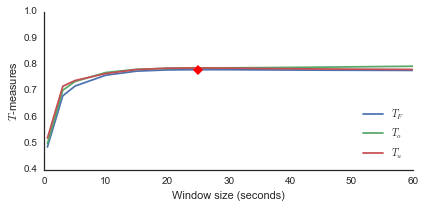

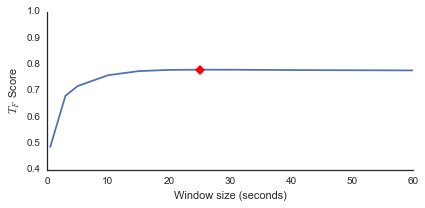

In [12]:
Tf_keys = ["Tf_" + str(w) for w in windows]
To_keys = ["To_" + str(w) for w in windows]
Tu_keys = ["Tu_" + str(w) for w in windows]
plt.figure(figsize=(6,3))
plt.plot(windows, results[Tf_keys].mean().values, label="$T_F$")
plt.plot(windows, results[To_keys].mean().values, label="$T_o$")
plt.plot(windows, results[Tu_keys].mean().values, label="$T_u$")
plt.plot(windows[np.argmax(results[Tf_keys].mean().values)], 
         np.max(results[Tf_keys].mean().values), 'rD')
plt.ylim((0.4,1))
plt.legend(loc='lower right')
plt.xlabel("Window size (seconds)")
plt.ylabel("$T$-measures")
sns.despine()
plt.tight_layout()
plt.savefig("../figs/exploring_w.pdf")

plt.figure(figsize=(6,3))
plt.plot(windows, results[Tf_keys].mean().values, label="$T_F$")
plt.plot(windows[np.argmax(results[Tf_keys].mean().values)], 
         np.max(results[Tf_keys].mean().values), 'rD')
plt.ylim((0.4,1))
plt.xlabel("Window size (seconds)")
plt.ylabel("$T_F$ Score")
sns.despine()
plt.tight_layout()
plt.savefig("../figs/exploring_w_Tf.pdf")